# Imports

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
def fix_layout(width:int=95):
    from IPython.core.display import display, HTML
    display(HTML('<style>.container { width:' + str(width) + '% !important; }</style>'))
    
fix_layout()

In [3]:
from nnpde.solve_area import Solve_Area
from tqdm.notebook import tqdm
import torch
import numpy as np
import matplotlib.pyplot as plt

In [4]:
from nnpde.utils.logs import enable_logging, logging 

# Setup

In [5]:
enable_logging(20)

#seed = 9 # Does not give problems
#torch.manual_seed(seed)
#np.random.seed(seed)

2021-07-29 14:41:33,074 - root - INFO - logs - logging enabled for level: 20


In [6]:
# log_prob has to be defined. also, backward of it will be calculated
my_dist = torch.distributions.multivariate_normal.MultivariateNormal(loc = torch.tensor([0., 0.]), 
                                                                     covariance_matrix = torch.tensor([[1., 0.], [0., 1.]]))

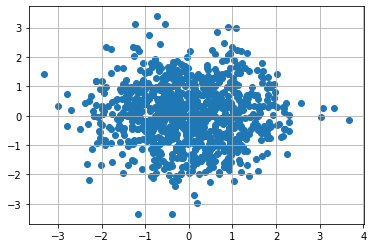

In [7]:
examp = my_dist.sample(torch.Size([1000]))
plt.scatter(examp[:, 0], examp[:, 1])
plt.grid()
plt.show()

In [8]:
n_dims = 2 #specify dimensionality of data
cube_coords = torch.tensor([[-4., 4.], [-4., 4.]]) # specify coordinate borders of cube
N = torch.tensor([128, 128]) # specify grid size of every dimension. 
# h (float) can be specified instead of N
# Note: distance between adjacent nodes h has to be the same across all dimensions

In [9]:
region_solver = Solve_Area(n_dims = n_dims, 
                           cube_coords = cube_coords, 
                           distribution = my_dist, 
                           N = N)

In [10]:
base_parameters = {
    "nb_layers": 3,
    "max_epochs": 300,
    "batch_size": 10,
    "stable_count": 10,
    "n_dims": n_dims,
    "optimizer": "Adadelta",
}

region_solver.train_model(base_parameters)

2021-07-29 14:41:58,507 - root - INFO - model - Using optimizer Adadelta


2021-07-29 14:41:58,828 - root - INFO - model - Training with max_epochs: 300, tol: 1e-06. Initial loss is 202490.359375
2021-07-29 14:41:59,641 - root - INFO - model - Epoch 0 with total loss 68968.5234375


KeyboardInterrupt: 

## Test on distribution

In [ ]:
def value_function(x):
    #x = [n_items, n_dims]
    #return (x**3).sum(dim=1)
    return (torch.sin(x**3)).sum(dim=1)

In [ ]:
samps = my_dist.sample([10000])

In [ ]:
region_solver.solve_setting(function = value_function, samples = samps)

In [ ]:
def regular_expectancy(f, p, test_amnt, sample_amnt):
    results = list()
    for i in tqdm(range(test_amnt)):
        samples = p.sample([sample_amnt])
        mean = f(samples).mean()
        results.append(mean.item())
    return results

In [ ]:
t_am = 100
s_am = 10**3
reg_exp = regular_expectancy(value_function, my_dist, t_am, s_am)

In [ ]:
def spec_exp(f, test_amnt, sample_amnt, region_solver, p):
    results = list()
    for i in tqdm(range(test_amnt)):
        samples = p.sample([sample_amnt])
        cv = region_solver.get_cv(samples)
        mean = (f(samples) - cv).mean()
        results.append(mean.item())
    return results

In [ ]:
cv_exp = spec_exp(value_function, t_am, s_am, region_solver, my_dist)

In [ ]:
def box_comp(a, b):                                                    
    data = [a, b]                                             
    plt.figure(figsize=(12,8))                 
    plt.boxplot(data, showfliers = False, labels =                              
                ["MC Vanila", "Diff CV"])
    plt.grid()
    plt.show()

In [ ]:
box_comp(reg_exp, cv_exp)